<a href="https://colab.research.google.com/github/NathanBouaziz/GPBP_Analytics_Tools/blob/main/Analytics%20Notebooks/Towards%20Optimal%20Facility%20Deployment%20-%20Nathan%20Bouaziz/Thesis%20Codes/Simulation_with_5_Facilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [ ]:
!pip install pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 27.1 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import itertools as it
from time import perf_counter as pc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time
from tqdm import tqdm
import subprocess, sys, shutil
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.dae import *
from pyomo.environ import *
import gurobipy as gp
from gurobipy import GRB

#Greedy Formulation

In [ ]:
def fast_greedy(w, JI, IJ):
    J = list(IJ.keys())

    gain = np.zeros(max(J)+1)
    coverage = np.zeros_like(w, dtype=np.uint16)

    related = { j : np.unique(np.concatenate([JI[i] for i in IJ[j]]))
                for j in J if len(IJ[j])
    }

    def mutation( w, cov, IJ, J, v ):
        return np.array( [w[IJ[j][cov[IJ[j]]==v]].sum() for j in J] )

    sol = []
    gains_log = []

    gain[J] = mutation( w, coverage, IJ, J, 0 )
    while True:
        s = gain.argmax()
        if gain[s] <= 0:
            break
        coverage[IJ[s]] += 1
        gains_log.append(gain[s])
        gain[related[s]] = mutation( w, coverage, IJ, related[s], 0 )
        sol.append(s)

    return np.array(sol), gains_log

#MILP Model with Pyomo


## Ensure preconditions

In [ ]:
def GetListOfInstalledPackages():
    res = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
    return { r.decode().split('==')[0] for r in res.split() }

In [ ]:
def EnsurePreConditionsAtColab():
    at_colab = "google.colab" in sys.modules
    if at_colab:
        installed = GetListOfInstalledPackages()
        if not 'pyomo' in installed:
            %pip install -q pyomo
        if not 'highspy' in installed:
            %pip install -q highspy
        if not shutil.which('/usr/bin/cbc'):
            !apt-get install -y -qq coinor-cbc
            assert(shutil.which('/usr/bin/cbc'))
    return at_colab

In [ ]:
at_colab = EnsurePreConditionsAtColab()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.5 MB/s eta 0:00:00
Selecting previously unselected package coinor-libcoinutils3v5:amd64.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../0-coinor-libcoinutils3v5_2.11.4+repack1-2_amd64.deb ...
Unpacking coinor-libcoinutils3v5:amd64 (2.11.4+repack1-2) ...
Selecting previously unselected package coinor-libosi1v5:amd64.
Preparing to unpack .../1-coinor-libosi1v5_0.108.6+repack1-2_amd64.deb ...
Unpacking coinor-libosi1v5:amd64 (0.108.6+repack1-2) ...
Selecting previously unselected package coinor-libclp1.
Preparing to unpack .../2-coinor-libclp1_1.17.5+repack1-1_amd64.deb ...
Unpacking coinor-libclp1 (1.17.5+repack1-1) ...
Selecting previously unselected package coinor-libcgl1:amd64.
Preparing to unpack .../3-coinor-libcgl1_0.60.3+repack1-3_amd64.deb ...
Unpacking coinor-libcgl1:amd64 (0.60.3+repack1-3) ...
Selecting previously unselected package coinor-libcbc3:amd64.
Preparing to u

In [ ]:
def ListAvailableSolvers():
    shell_command = "pyomo help --solvers"
    output = subprocess.check_output(shell_command, shell=True).decode()
    return [
        line.strip()[1:]
        for line in output.split()
        if line.strip().startswith("+") and not line.strip().endswith(")")
    ]

In [ ]:
available_solvers = ListAvailableSolvers()
print(available_solvers)

['appsi_gurobi', 'appsi_highs', 'cbc', 'gdpopt', 'gdpopt.enumerate', 'gdpopt.gloa', 'gdpopt.lbb', 'gdpopt.loa', 'gdpopt.ric', 'gurobi', 'gurobi_direct', 'gurobi_direct_v2', 'gurobi_persistent', 'gurobi_v2', 'mindtpy', 'mindtpy.ecp', 'mindtpy.fp', 'mindtpy.goa', 'mindtpy.oa', 'mpec_minlp', 'mpec_nlp', 'multistart', 'scipy.fsolve', 'scipy.newton', 'scipy.root', 'scipy.secant-newton', 'trustregion']


##Model Formulation

In [ ]:
def model_max_covering(w, I, J, JI, T):
    m = ConcreteModel()

    m.I = Set(initialize=I)
    m.J = Set(initialize=J)
    m.T = Set(initialize=T)

    m.x = Var(m.J, m.T, within=Binary)
    m.y = Var(m.I, m.T, within=Binary)

    def obj_rule(m):
        return sum(w[i] * m.y[i, t] for t in m.T for i in m.I)
    m.obj = Objective(rule=obj_rule, sense=maximize)

    def coverage_constraint_rule(m, i, t):
        return m.y[i, t] <= sum(sum(m.x[j, tau] for j in JI[i]) for tau in range(1, t+1))
    m.coverage_constraint = Constraint(m.I, m.T, rule=coverage_constraint_rule)

    def facility_deployment_constraint_rule(m, t):
        return sum(m.x[j, t] for j in m.J) == t
    m.facility_deployment_constraint = Constraint(m.T, rule=facility_deployment_constraint_rule)

    def facility_continuity_constraint_rule(m, j, t):
        if t == 1:
            return Constraint.Skip
        return m.x[j, t-1] <= m.x[j, t]
    m.facility_continuity_constraint = Constraint(m.J, m.T, rule=facility_continuity_constraint_rule)

    return m

#MILP Model with Gurobi


In [ ]:
def model_max_covering_gurobi(w, I, J, JI, T):
    m = gp.Model()

    x = m.addVars(J, T, vtype=GRB.BINARY, name="x")
    y = m.addVars(I, T, vtype=GRB.BINARY, name="y")

    obj_expr = gp.quicksum(w[i] * y[i, t] for t in T for i in I)
    m.setObjective(obj_expr, sense=GRB.MAXIMIZE)

    for i in I:
        for t in T:
            coverage_expr = y[i, t] <= gp.quicksum(x[j, tau] for j in JI[i] for tau in range(1, t + 1))
            m.addConstr(coverage_expr, name=f"coverage_{i}_{t}")

    for t in T:
        deployment_expr = gp.quicksum(x[j, t] for j in J) == t
        m.addConstr(deployment_expr, name=f"deployment_{t}")

    for j in J:
        for t in T:
            if t > 1:
                continuity_expr = x[j, t-1] <= x[j, t]
                m.addConstr(continuity_expr, name=f"continuity_{j}_{t}")

    return m, T

#Synthetic Scenario with 5 Facilities


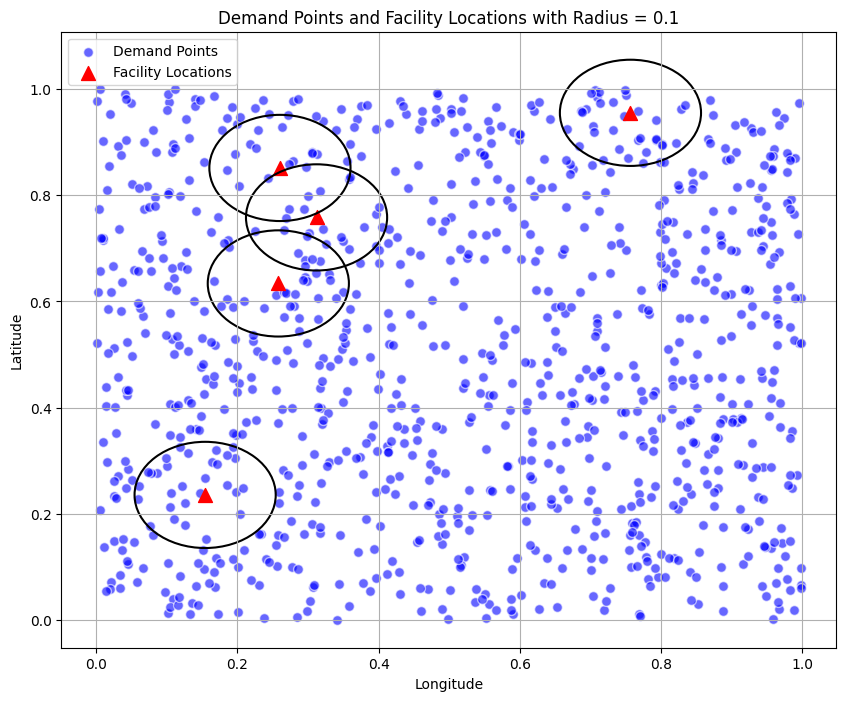

In [ ]:
np.random.seed(0)

demand_points = {
    "Latitude": np.random.rand(1000),
    "Longitude": np.random.rand(1000),
    "Weight": np.random.randint(1, 5, 1000)
}

demand_df = pd.DataFrame(demand_points)

facility_points = {
    "Latitude": np.random.rand(5),
    "Longitude": np.random.rand(5)
}

facility_df = pd.DataFrame(facility_points)

plt.figure(figsize=(10, 8))
plt.scatter(demand_df['Longitude'], demand_df['Latitude'], s=50, c='blue', alpha=0.6, edgecolors='w', label='Demand Points')
plt.scatter(facility_df['Longitude'], facility_df['Latitude'], marker='^', s=100, c='red', label='Facility Locations')

for index, row in facility_df.iterrows():
    circle = Circle((row['Longitude'], row['Latitude']), radius=0.1, color='black', fill=False, linewidth=1.5)
    plt.gca().add_patch(circle)

plt.title('Demand Points and Facility Locations with Radius = 0.1')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.show()

Now discard all demand nodes that are not in the radius of any facility

Filtered Demand Points DataFrame:
     Latitude  Longitude  Weight  Within_Radius
12   0.568045   0.287545       2           True
17   0.832620   0.243678       4           True
19   0.870012   0.753240       2           True
35   0.617635   0.349993       1           True
36   0.612096   0.254382       1           True
..        ...        ...     ...            ...
971  0.176499   0.075611       1           True
979  0.591065   0.176333       1           True
982  0.723941   0.297970       4           True
984  0.922299   0.731930       1           True
987  0.833982   0.359107       3           True

[128 rows x 4 columns]


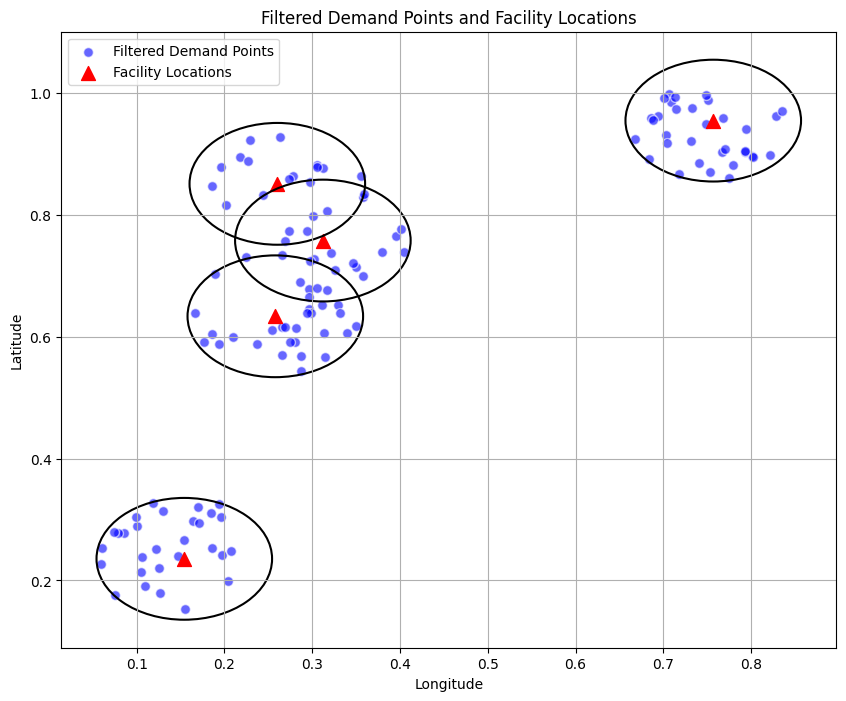

In [ ]:
radius = 0.1

def is_within_radius(demand_lat, demand_lon, facility_df, radius):
    for index, row in facility_df.iterrows():
        dist = np.sqrt((demand_lat - row['Latitude'])**2 + (demand_lon - row['Longitude'])**2)
        if dist <= radius:
            return True
    return False

demand_df['Within_Radius'] = demand_df.apply(lambda row: is_within_radius(row['Latitude'], row['Longitude'], facility_df, radius), axis=1)
filtered_demand_df = demand_df[demand_df['Within_Radius']]

print("Filtered Demand Points DataFrame:")
print(filtered_demand_df)

plt.figure(figsize=(10, 8))
plt.scatter(filtered_demand_df['Longitude'], filtered_demand_df['Latitude'], s=50, c='blue', alpha=0.6, edgecolors='w', label='Filtered Demand Points')
plt.scatter(facility_df['Longitude'], facility_df['Latitude'], marker='^', s=100, c='red', label='Facility Locations')

for index, row in facility_df.iterrows():
    circle = Circle((row['Longitude'], row['Latitude']), radius=0.1, color='black', fill=False, linewidth=1.5)
    plt.gca().add_patch(circle)

plt.title('Filtered Demand Points and Facility Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def is_within_radius(demand_lat, demand_lon, facility_lat, facility_lon, radius):
    dist = np.sqrt((demand_lat - facility_lat)**2 + (demand_lon - facility_lon)**2)
    return dist <= radius

filtered_demand_indices = []
for demand_index, demand_row in demand_df.iterrows():
    for facility_index, facility_row in facility_df.iterrows():
        if is_within_radius(demand_row['Latitude'], demand_row['Longitude'], facility_row['Latitude'], facility_row['Longitude'], radius):
            filtered_demand_indices.append(demand_index)
            break

filtered_demand_df = demand_df.loc[filtered_demand_indices].reset_index(drop=True)

coverage_dict = {}

for facility_index, facility_row in facility_df.iterrows():
    covered_indices = []
    for demand_index, demand_row in filtered_demand_df.iterrows():
        if is_within_radius(demand_row['Latitude'], demand_row['Longitude'], facility_row['Latitude'], facility_row['Longitude'], radius):
            covered_indices.append(demand_index)
    coverage_dict[facility_index] = np.array(covered_indices)

print("Coverage Dictionary:")
print(coverage_dict)

demand_to_facility_dict = {}

for demand_index in range(len(filtered_demand_df)):
    demand_to_facility_dict[demand_index] = []

for facility_index, covered_indices in coverage_dict.items():
    for demand_index in covered_indices:
        demand_to_facility_dict[demand_index].append(facility_index)

for demand_index in demand_to_facility_dict:
    demand_to_facility_dict[demand_index] = np.array(demand_to_facility_dict[demand_index])

print("Demand to Facility Dictionary:")
print(demand_to_facility_dict)

Coverage Dictionary:
{0: array([  1,  21,  22,  29,  34,  36,  57,  67,  78,  79,  89,  90,  95,
        97, 104, 112, 114, 119, 120, 122]), 1: array([  9,  14,  25,  26,  27,  28,  42,  47,  49,  50,  51,  58,  64,
        66,  72,  75,  80,  86,  87,  88,  94,  96,  99, 108, 115, 116,
       118, 121, 123]), 2: array([ 10,  11,  13,  18,  21,  23,  30,  34,  36,  38,  54,  62,  63,
        68,  74,  76,  78,  91, 101, 103, 106, 109, 114, 119, 125, 127]), 3: array([  0,   3,   4,   5,   6,   7,   8,  10,  15,  16,  20,  35,  39,
        41,  45,  48,  52,  54,  63,  65,  74,  81,  82,  83,  84,  91,
       100, 102, 107, 113, 124, 125]), 4: array([  2,  12,  17,  19,  24,  31,  32,  33,  37,  40,  43,  44,  46,
        53,  55,  56,  59,  60,  61,  69,  70,  71,  73,  77,  85,  92,
        93,  98, 105, 110, 111, 117, 126])}
Demand to Facility Dictionary:
{0: array([3]), 1: array([0]), 2: array([4]), 3: array([3]), 4: array([3]), 5: array([3]), 6: array([3]), 7: array([3]), 8: array([

#Performances of the different solution methods

##Greedy Algorithm

In [ ]:
demand_weights = np.array(filtered_demand_df['Weight'])

start_time = time.time()

selected_facilities, gains_log = fast_greedy(demand_weights, demand_to_facility_dict, coverage_dict)

end_time = time.time()

elapsed_time = end_time - start_time

cumulative_sums = []
current_sum = 0
total_sum_of_sums = 0

for gain in gains_log:
    current_sum += gain
    total_sum_of_sums += current_sum

print("Sum of sums:", total_sum_of_sums)
print("Chosen facilities:", selected_facilities)
print(f"Time taken: {elapsed_time:.4f} seconds")

Sum of sums: 1109.0
Chosen facilities: [4 3 1 2 0]
Time taken: 0.0010 seconds


##MILP Model

In [ ]:
weights = filtered_demand_df['Weight'].values
I_range = range(len(filtered_demand_df))
J_range = range(len(facility_df))
T_range = range(1, len(facility_df) + 1)

Gurobi solver

In [ ]:
def optimize_model_with_output(model_gurobi):
    m, T = model_gurobi

    start_time = time.time()
    with tqdm(total=2) as pbar:
        m.optimize()
        pbar.update(1)

        if m.status == GRB.OPTIMAL:
            print("Optimal Solution Found:")
            print("Optimal Sum of Coverage:", m.objVal)

            for t in T_range:
                print(f"Facilities chosen at time {t}:")
                for j in J_range:
                    if m.getVarByName(f"x[{j},{t}]").x > 0.5:
                        print(f"Facility {j}")
            else:
                end_time = time.time()
                print(f"Computation Time: {end_time - start_time:.4f} seconds")

        else:
            print("No optimal solution found.")
            end_time = time.time()
            print(f"Computation Time: {end_time - start_time:.4f} seconds")

In [ ]:
model_gurobi = model_max_covering_gurobi(weights, I_range, J_range, demand_to_facility_dict, T_range)

optimize_model_with_output(model_gurobi)

Restricted license - for non-production use only - expires 2025-11-24


  0%|          | 0/2 [00:00<?, ?it/s]

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 665 rows, 665 columns and 2805 nonzeros
Model fingerprint: 0x9b8db845
Variable types: 0 continuous, 665 integer (665 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 1062.0000000
Presolve removed 635 rows and 634 columns
Presolve time: 0.00s
Presolved: 30 rows, 31 columns, 87 nonzeros
Variable types: 0 continuous, 31 integer (31 binary)
Found heuristic solution: objective 1079.0000000

Root relaxation: objective 1.135000e+03, 21 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

 50%|█████     | 1/2 [00:00<00:00, 14.56it/s]

Optimal Solution Found:
Optimal Sum of Coverage: 1109.0
Facilities chosen at time 1:
Facility 4
Facilities chosen at time 2:
Facility 3
Facility 4
Facilities chosen at time 3:
Facility 1
Facility 3
Facility 4
Facilities chosen at time 4:
Facility 1
Facility 2
Facility 3
Facility 4
Facilities chosen at time 5:
Facility 0
Facility 1
Facility 2
Facility 3
Facility 4
Computation Time: 0.0799 seconds


cbc solver

In [ ]:
model_instance = model_max_covering(weights, I_range, J_range, demand_to_facility_dict, T_range)

In [ ]:
print("CBC solver")
start_time = time.time()
solver = SolverFactory('cbc')

with tqdm(total=2) as pbar:
    result_CBC = solver.solve(model_instance)
    pbar.update(1)
    end_time_CBC = time.time()

    if result_CBC.solver.termination_condition == TerminationCondition.optimal:
        print("Solution found")
        print("Optimal Sum of Coverage:", model_instance.obj())


        for t in model_instance.T:
            print(f"Facilities chosen at time {t}:")
            for j in model_instance.J:
                if model_instance.x[j, t].value > 0.5:
                    print(f"Facility {j}")
    else:
        print("Solver could not find an optimal solution")

print(f"Computation time (CBC): {end_time_CBC - start_time} seconds")

CBC solver


 50%|█████     | 1/2 [00:01<00:01,  1.56s/it]

Solution found
Optimal Sum of Coverage: 1109.0
Facilities chosen at time 1:
Facility 4
Facilities chosen at time 2:
Facility 3
Facility 4
Facilities chosen at time 3:
Facility 1
Facility 3
Facility 4
Facilities chosen at time 4:
Facility 1
Facility 2
Facility 3
Facility 4
Facilities chosen at time 5:
Facility 0
Facility 1
Facility 2
Facility 3
Facility 4
Computation time (CBC): 1.5589826107025146 seconds


appsi_highs solver

In [ ]:
print("APPSI solver")
start_time = time.time()
solver = SolverFactory('appsi_highs')

with tqdm(total=2) as pbar:
    result_highs = solver.solve(model_instance)
    pbar.update(1)
    end_time_highs = time.time()

    if result_highs.solver.termination_condition == TerminationCondition.optimal:
        print("Solution Found")
        print("Optimal Sum of Coverage:", model_instance.obj())

        for t in model_instance.T:
            print(f"Facilities chosen at time {t}:")
            for j in model_instance.J:
                if model_instance.x[j, t].value > 0.5:
                    print(f"Facility {j}")
    else:
        print("Solver could not find an optimal solution")

print(f"Computation Time (APPSI): {end_time_highs - start_time} seconds")

APPSI solver


 50%|█████     | 1/2 [00:02<00:02,  2.01s/it]

Solution Found
Optimal Sum of Coverage: 1109.0
Facilities chosen at time 1:
Facility 4
Facilities chosen at time 2:
Facility 3
Facility 4
Facilities chosen at time 3:
Facility 1
Facility 3
Facility 4
Facilities chosen at time 4:
Facility 1
Facility 2
Facility 3
Facility 4
Facilities chosen at time 5:
Facility 0
Facility 1
Facility 2
Facility 3
Facility 4
Computation Time (APPSI): 2.0262866020202637 seconds
